In [10]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import fitsio
import pandas as pd
import os

In [14]:
import pandas as pd
import numpy as np
import os

# 设置路径
qso_dir = '/home/wbc/code3/llm-spectro-agent/data/0/mock_set1'
qso_csv_path = os.path.join(qso_dir, 'truth_catalog.csv')

# 读取CSV文件
qso_csv = pd.read_csv(qso_csv_path)

print("CSV文件列名:", qso_csv.columns.tolist())
print("数据形状:", qso_csv.shape)
print("LABEL分布:")
print(qso_csv['LABEL'].value_counts())

def sample_indices_by_label(qso_data, high_count=8, medium_count=8, low_count=4, random_state=42):
    """
    从QSO数据中按LABEL类别随机抽取INDEX
    
    参数:
    qso_data: 包含QSO信息的DataFrame
    high_count: 从high类别抽取的数量
    medium_count: 从medium类别抽取的数量
    low_count: 从low类别抽取的数量
    random_state: 随机种子，确保结果可复现
    
    返回:
    包含选中INDEX的列表
    """
    # 设置随机种子
    np.random.seed(random_state)
    
    # 初始化结果列表
    selected_indices = []
    
    # 按类别抽取
    for label, count in [('high', high_count), ('mid', medium_count), ('low', low_count)]:
        # 筛选当前类别的数据
        label_data = qso_data[qso_data['LABEL'] == label]
        
        if len(label_data) == 0:
            print(f"警告: 没有找到LABEL为'{label}'的数据")
            continue
        
        if len(label_data) < count:
            print(f"警告: {label}类别只有{len(label_data)}条数据，少于要求的{count}条，将抽取所有可用数据")
            count = len(label_data)
        
        # 随机抽取指定数量的INDEX
        sampled = label_data['INDEX'].sample(n=count, random_state=random_state).tolist()
        selected_indices.extend(sampled)
        
        print(f"{label}类别: 抽取了{len(sampled)}个INDEX")
    
    return selected_indices

# 执行抽样
selected_indices = sample_indices_by_label(qso_csv, high_count=8, medium_count=8, low_count=4)

print("\n选中的INDEX列表:")
print(selected_indices)
print(f"总共选中了 {len(selected_indices)} 个INDEX")

# 可选：查看选中样本的详细信息
if len(selected_indices) > 0:
    print("\n选中样本的详细信息:")
    selected_data = qso_csv[qso_csv['INDEX'].isin(selected_indices)]
    print(selected_data[['FILENAME', 'INDEX', 'LABEL', 'Z_QSO']].sort_values('LABEL'))
    
    # 统计每个LABEL的抽取数量
    print("\n抽取统计:")
    print(selected_data['LABEL'].value_counts())

CSV文件列名: ['FILENAME', 'INDEX', 'LABEL', 'Z_QSO', 'Z_DLA', 'LOGNHI', 'SNRMEAN', 'RNGSEED']
数据形状: (100, 8)
LABEL分布:
LABEL
high    40
mid     30
low     30
Name: count, dtype: int64
high类别: 抽取了8个INDEX
mid类别: 抽取了8个INDEX
low类别: 抽取了4个INDEX

选中的INDEX列表:
[19, 16, 15, 26, 4, 12, 37, 27, 67, 55, 63, 57, 48, 49, 68, 64, 97, 85, 93, 87]
总共选中了 20 个INDEX

选中样本的详细信息:
                        FILENAME  INDEX LABEL     Z_QSO
4   csst_qso_004_z2.75_high.fits      4  high  2.746979
12  csst_qso_012_z3.48_high.fits     12  high  3.480360
15  csst_qso_015_z2.36_high.fits     15  high  2.363678
16  csst_qso_016_z2.21_high.fits     16  high  2.213132
19  csst_qso_019_z2.79_high.fits     19  high  2.786680
26  csst_qso_026_z3.29_high.fits     26  high  3.294791
27  csst_qso_027_z3.40_high.fits     27  high  3.401122
37  csst_qso_037_z1.69_high.fits     37  high  1.685230
87   csst_qso_087_z1.52_low.fits     87   low  1.522496
85   csst_qso_085_z2.00_low.fits     85   low  2.002402
97   csst_qso_097_z3.36_low.f

In [24]:
QSO_sample = np.c_[selected_data['INDEX'], ['QSO']*len(selected_data['INDEX']), selected_data['LABEL'], selected_data['Z_QSO']]

In [16]:
elg_dir = '/home/wbc/code3/llm-spectro-agent/data/0/dataset'
elg_path = os.path.join(elg_dir, 'all_indices.csv')

# 读取CSV文件
elg_csv = pd.read_csv(elg_path)

In [25]:
galaxy_sample = np.c_[elg_csv['idx'], ['galaxy']*len(elg_csv['idx']), elg_csv['SNR'], [0]*len(elg_csv['idx'])]

In [26]:
# 合并样本数组并打乱顺序
def combine_and_shuffle_samples(QSO_sample, galaxy_sample, random_seed=42):
    """
    合并QSO和galaxy样本，并打乱顺序
    
    参数:
    QSO_sample: QSO样本数组
    galaxy_sample: galaxy样本数组
    random_seed: 随机种子，确保结果可复现
    
    返回:
    合并并打乱顺序后的数组
    """
    # 1. 合并两个数组
    combined_sample = np.concatenate([QSO_sample, galaxy_sample], axis=0)
    
    print(f"合并前数据量:")
    print(f"  QSO样本: {len(QSO_sample)} 条")
    print(f"  Galaxy样本: {len(galaxy_sample)} 条")
    print(f"  总计: {len(combined_sample)} 条")
    
    # 2. 设置随机种子以确保结果可复现
    np.random.seed(random_seed)
    
    # 3. 获取随机排列的索引
    shuffled_indices = np.random.permutation(len(combined_sample))
    
    # 4. 使用索引重新排列数组
    shuffled_sample = combined_sample[shuffled_indices]
    
    return shuffled_sample

# 使用示例
# 假设已经加载了QSO_sample和galaxy_sample
# QSO_sample = np.c_[...]
# galaxy_sample = np.c_[...]

# 合并并打乱
shuffled_samples = combine_and_shuffle_samples(QSO_sample, galaxy_sample)

# 打印结果
print("\n打乱后的前10个样本:")
for i, sample in enumerate(shuffled_samples[:10]):
    print(f"  样本{i+1}: INDEX={sample[0]}, TYPE={sample[1]}, SNR={sample[2]}, Z={sample[3]}")

# 统计信息
print("\n合并后样本统计:")
unique_types, type_counts = np.unique(shuffled_samples[:, 1], return_counts=True)
for t, c in zip(unique_types, type_counts):
    print(f"  {t}: {c} 条")

unique_snr, snr_counts = np.unique(shuffled_samples[:, 2], return_counts=True)
print("\nSNR质量分布:")
for s, c in zip(unique_snr, snr_counts):
    print(f"  {s}: {c} 条")

# 保存结果到文件
output_dir = '/home/wbc/code3/llm-spectro-agent/data/0/combined_samples'
os.makedirs(output_dir, exist_ok=True)

# 保存为CSV文件
output_csv = os.path.join(output_dir, 'combined_shuffled_samples.csv')
df_combined = pd.DataFrame(shuffled_samples, columns=['INDEX', 'TYPE', 'SNR_QUALITY', 'REDSHIFT'])
df_combined.to_csv(output_csv, index=False)
print(f"\n合并后的样本已保存到: {output_csv}")

# 保存为numpy文件
output_npy = os.path.join(output_dir, 'combined_shuffled_samples.npy')
np.save(output_npy, shuffled_samples)
print(f"合并后的样本已保存到: {output_npy}")

# 可选：创建便于阅读的文本文件
output_txt = os.path.join(output_dir, 'combined_shuffled_samples.txt')
with open(output_txt, 'w') as f:
    f.write("INDEX, TYPE, SNR_QUALITY, REDSHIFT\n")
    f.write("==================================\n")
    for sample in shuffled_samples:
        f.write(f"{sample[0]}, {sample[1]}, {sample[2]}, {sample[3]}\n")
print(f"合并后的样本已保存到: {output_txt}")

# 验证随机化效果
print("\n验证随机化效果:")
print("前5个样本的TYPE分布:")
first_5_types = shuffled_samples[:5, 1]
unique_first_5, counts_first_5 = np.unique(first_5_types, return_counts=True)
for t, c in zip(unique_first_5, counts_first_5):
    print(f"  {t}: {c} 条")

合并前数据量:
  QSO样本: 20 条
  Galaxy样本: 20 条
  总计: 40 条

打乱后的前10个样本:
  样本1: INDEX=97, TYPE=QSO, SNR=low, Z=3.3609878221642
  样本2: INDEX=85, TYPE=QSO, SNR=low, Z=2.0024017391762072
  样本3: INDEX=68, TYPE=QSO, SNR=mid, Z=1.368721891171687
  样本4: INDEX=13664, TYPE=galaxy, SNR=high, Z=0
  样本5: INDEX=19, TYPE=QSO, SNR=high, Z=2.786679786777765
  样本6: INDEX=63, TYPE=QSO, SNR=mid, Z=1.2308597522416134
  样本7: INDEX=16058, TYPE=galaxy, SNR=low, Z=0
  样本8: INDEX=5528, TYPE=galaxy, SNR=high, Z=0
  样本9: INDEX=2354, TYPE=galaxy, SNR=low, Z=0
  样本10: INDEX=27, TYPE=QSO, SNR=high, Z=3.4011217904084563

合并后样本统计:
  QSO: 20 条
  galaxy: 20 条

SNR质量分布:
  high: 16 条
  low: 8 条
  mid: 16 条

合并后的样本已保存到: /home/wbc/code3/llm-spectro-agent/data/0/combined_samples/combined_shuffled_samples.csv
合并后的样本已保存到: /home/wbc/code3/llm-spectro-agent/data/0/combined_samples/combined_shuffled_samples.npy
合并后的样本已保存到: /home/wbc/code3/llm-spectro-agent/data/0/combined_samples/combined_shuffled_samples.txt

验证随机化效果:
前5个样本的TYPE分布:
  QSO

In [31]:
print(shuffled_samples[0])

[97 'QSO' 'low' 3.3609878221642]


In [32]:
import shutil
path_0 = '/home/wbc/code3/llm-spectro-agent/data/test_set_3/0'
paaath = '/home/wbc/code3/llm-spectro-agent/data/test_set_3/input'
for i in range(len(shuffled_samples)):
    ss = shuffled_samples[i]
    if ss[1] == 'QSO':
        # 把 i 补齐到3位，例如 001, 002, 003
        ii = f"{ss[0]:03d}"
        name = f"csst_qso_{ii}"

        # 在 paath 中寻找name开头的文件
        files = [f for f in os.listdir(paaath) if f.startswith(name)]
        if len(files) > 0:
            file_path = os.path.join(paaath, files[0])
        # 将 file_path 存储到 path_0/i.fits
            shutil.copy(file_path, os.path.join(path_0, f"{i}.fits"))
    else:
        name = f"{ss[0]}.fits"
        shutil.copy(os.path.join(paaath, name), os.path.join(path_0, f"{i}.fits"))


In [41]:
import numpy as np

def split_samples_balanced(shuffled_samples, random_seed=42):
    """
    将shuffled_samples分成两组，每组包含：
    - QSO: 4high, 4mid, 2low
    - elg: 4high, 4mid, 2low
    
    返回两个分组在shuffled_samples中的序号
    """
    np.random.seed(random_seed)
    
    # 分别提取QSO和elg样本
    qso_samples = shuffled_samples[shuffled_samples[:, 1] == 'QSO']
    elg_samples = shuffled_samples[shuffled_samples[:, 1] == 'galaxy']
    
    print(f"QSO样本总数: {len(qso_samples)}")
    print(f"elg样本总数: {len(elg_samples)}")
    
    # 获取每个样本在原始shuffled_samples中的索引
    qso_indices = np.where(shuffled_samples[:, 1] == 'QSO')[0]
    elg_indices = np.where(shuffled_samples[:, 1] == 'galaxy')[0]
    
    # 创建映射：原始索引 -> 样本在子集中的位置
    qso_index_map = {i: idx for idx, i in enumerate(qso_indices)}
    elg_index_map = {i: idx for idx, i in enumerate(elg_indices)}
    
    # 按SNR质量分组
    qso_high = qso_samples[qso_samples[:, 2] == 'high']
    qso_mid = qso_samples[qso_samples[:, 2] == 'mid']  # 注意：QSO的标签是'medium'
    qso_low = qso_samples[qso_samples[:, 2] == 'low']
    
    elg_high = elg_samples[elg_samples[:, 2] == 'high']
    elg_mid = elg_samples[elg_samples[:, 2] == 'mid']  # 注意：elg的标签是'mid'
    elg_low = elg_samples[elg_samples[:, 2] == 'low']
    
    print("\nQSO各SNR质量分布:")
    print(f"  high: {len(qso_high)}, mid: {len(qso_mid)}, low: {len(qso_low)}")
    print("\nelg各SNR质量分布:")
    print(f"  high: {len(elg_high)}, mid: {len(elg_mid)}, low: {len(elg_low)}")
    
    # 检查每个类别是否有足够的样本
    required_counts = {
        'qso': {'high': 8, 'mid': 8, 'low': 4},  # 两组总共需要
        'elg': {'high': 8, 'mid': 8, 'low': 4}
    }
    
    available_counts = {
        'qso': {'high': len(qso_high), 'mid': len(qso_mid), 'low': len(qso_low)},
        'elg': {'high': len(elg_high), 'mid': len(elg_mid), 'low': len(elg_low)}
    }
    
    for obj_type in ['qso', 'elg']:
        for snr in ['high', 'mid', 'low']:
            available = available_counts[obj_type][snr]
            required = required_counts[obj_type][snr]
            if available < required:
                print(f"警告: {obj_type}的{snr}类别只有{available}个样本，少于需要的{required}个")
    
    # 获取每个类别样本在原始shuffled_samples中的索引
    def get_original_indices(samples, obj_type):
        """获取样本在原始shuffled_samples中的索引"""
        indices = []
        for sample in samples:
            # 查找这个样本在原始数组中的位置
            mask = (shuffled_samples[:, 0] == sample[0]) & (shuffled_samples[:, 1] == sample[1])
            idx = np.where(mask)[0]
            if len(idx) > 0:
                indices.append(idx[0])
        return indices
    
    qso_high_indices = get_original_indices(qso_high, 'QSO')
    qso_mid_indices = get_original_indices(qso_mid, 'QSO')
    qso_low_indices = get_original_indices(qso_low, 'QSO')
    
    elg_high_indices = get_original_indices(elg_high, 'galaxy')
    elg_mid_indices = get_original_indices(elg_mid, 'galaxy')
    elg_low_indices = get_original_indices(elg_low, 'galaxy')
    
    # 随机打乱每个类别内的样本
    np.random.shuffle(qso_high_indices)
    np.random.shuffle(qso_mid_indices)
    np.random.shuffle(qso_low_indices)
    np.random.shuffle(elg_high_indices)
    np.random.shuffle(elg_mid_indices)
    np.random.shuffle(elg_low_indices)
    
    # 分配样本到两个组
    group1_indices = []
    group2_indices = []
    
    # QSO: 每组4high, 4mid, 2low
    group1_indices.extend(qso_high_indices[:4])
    group2_indices.extend(qso_high_indices[4:8])
    
    group1_indices.extend(qso_mid_indices[:4])
    group2_indices.extend(qso_mid_indices[4:8])
    
    group1_indices.extend(qso_low_indices[:2])
    group2_indices.extend(qso_low_indices[2:4])
    
    # elg: 每组4high, 4mid, 2low
    group1_indices.extend(elg_high_indices[:4])
    group2_indices.extend(elg_high_indices[4:8])
    
    group1_indices.extend(elg_mid_indices[:4])
    group2_indices.extend(elg_mid_indices[4:8])
    
    group1_indices.extend(elg_low_indices[:2])
    group2_indices.extend(elg_low_indices[2:4])
    
    # 转换回numpy数组并排序（可选）
    group1_indices = np.array(group1_indices)
    group2_indices = np.array(group2_indices)
    
    # 验证分组结果
    print("\n分组验证:")
    print(f"组1样本数: {len(group1_indices)}")
    print(f"组2样本数: {len(group2_indices)}")
    
    # 获取每组样本的详细信息用于验证
    group1_samples = shuffled_samples[group1_indices]
    group2_samples = shuffled_samples[group2_indices]
    
    def count_samples_by_type_and_snr(samples):
        """统计样本的类型和SNR分布"""
        counts = {}
        for sample in samples:
            obj_type = sample[1]
            snr = sample[2]
            key = f"{obj_type}_{snr}"
            counts[key] = counts.get(key, 0) + 1
        return counts
    
    group1_counts = count_samples_by_type_and_snr(group1_samples)
    group2_counts = count_samples_by_type_and_snr(group2_samples)
    
    print("\n组1分布:")
    for key, count in sorted(group1_counts.items()):
        print(f"  {key}: {count}")
    
    print("\n组2分布:")
    for key, count in sorted(group2_counts.items()):
        print(f"  {key}: {count}")
    
    return group1_indices, group2_indices

# 使用函数
group1_indices, group2_indices = split_samples_balanced(shuffled_samples)

print("\n组1在shuffled_samples中的序号:")
print(group1_indices)
print("\n组2在shuffled_samples中的序号:")
print(group2_indices)

# 可选：查看每组的具体样本
print("\n组1样本详情:")
for i, idx in enumerate(group1_indices):
    sample = shuffled_samples[idx]
    print(f"  样本{i+1} (原始位置{idx}): INDEX={sample[0]}, TYPE={sample[1]}, SNR={sample[2]}, Z={sample[3]}")

print("\n组2样本详情:")
for i, idx in enumerate(group2_indices):
    sample = shuffled_samples[idx]
    print(f"  样本{i+1} (原始位置{idx}): INDEX={sample[0]}, TYPE={sample[1]}, SNR={sample[2]}, Z={sample[3]}")

QSO样本总数: 20
elg样本总数: 20

QSO各SNR质量分布:
  high: 8, mid: 8, low: 4

elg各SNR质量分布:
  high: 8, mid: 8, low: 4

分组验证:
组1样本数: 20
组2样本数: 20

组1分布:
  QSO_high: 4
  QSO_low: 2
  QSO_mid: 4
  galaxy_high: 4
  galaxy_low: 2
  galaxy_mid: 4

组2分布:
  QSO_high: 4
  QSO_low: 2
  QSO_mid: 4
  galaxy_high: 4
  galaxy_low: 2
  galaxy_mid: 4

组1在shuffled_samples中的序号:
[ 9 25  4 36 12 37  2 15  0  1 35 10  3 30 31 19 13 38  8  6]

组2在shuffled_samples中的序号:
[18 22 20 28 21 11  5 32 16 34 33 17  7 24 26 29 14 23 39 27]

组1样本详情:
  样本1 (原始位置9): INDEX=27, TYPE=QSO, SNR=high, Z=3.4011217904084563
  样本2 (原始位置25): INDEX=15, TYPE=QSO, SNR=high, Z=2.363678432053318
  样本3 (原始位置4): INDEX=19, TYPE=QSO, SNR=high, Z=2.786679786777765
  样本4 (原始位置36): INDEX=37, TYPE=QSO, SNR=high, Z=1.6852297516098016
  样本5 (原始位置12): INDEX=64, TYPE=QSO, SNR=mid, Z=1.0723796056211967
  样本6 (原始位置37): INDEX=67, TYPE=QSO, SNR=mid, Z=3.3795533969643907
  样本7 (原始位置2): INDEX=68, TYPE=QSO, SNR=mid, Z=1.368721891171687
  样本8 (原始位置15): INDEX=48, TYPE=Q

In [46]:
print(group1_indices)
print(group2_indices)

[ 9 25  4 36 12 37  2 15  0  1 35 10  3 30 31 19 13 38  8  6]
[18 22 20 28 21 11  5 32 16 34 33 17  7 24 26 29 14 23 39 27]


In [47]:
print(shuffled_samples[0])

[97 'QSO' 'low' 3.3609878221642]


9
Filename: /home/wbc/code3/llm-spectro-agent/data/test_set_3/0/9.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  WAVELENGTH    1 ImageHDU         7   (2774,)   float32   
  2  FLUX          1 ImageHDU         7   (2774,)   float32   
  3  FLUX_RAW      1 ImageHDU         7   (2774,)   float32   
None
25
Filename: /home/wbc/code3/llm-spectro-agent/data/test_set_3/0/25.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  WAVELENGTH    1 ImageHDU         7   (2774,)   float32   
  2  FLUX          1 ImageHDU         7   (2774,)   float32   
  3  FLUX_RAW      1 ImageHDU         7   (2774,)   float32   
None
4
Filename: /home/wbc/code3/llm-spectro-agent/data/test_set_3/0/4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  WAVELENGTH    1 ImageHDU         7   (2774,)   float3

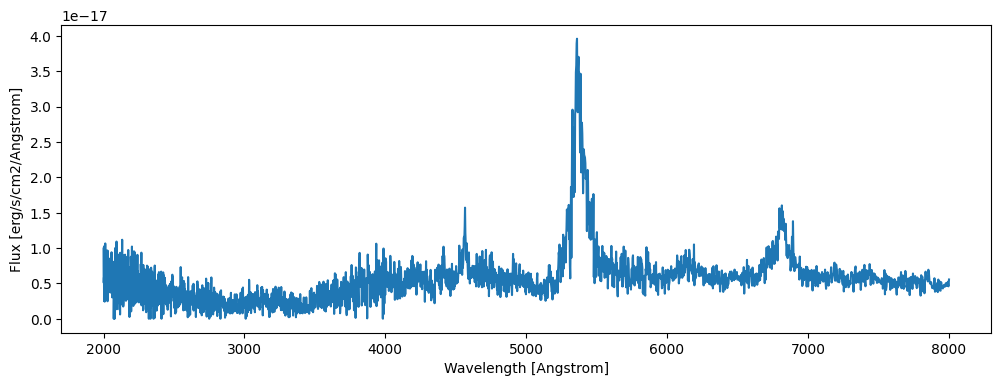

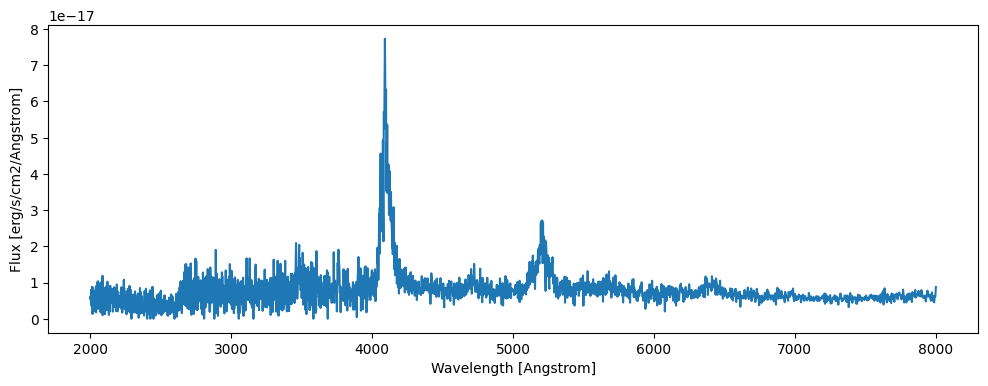

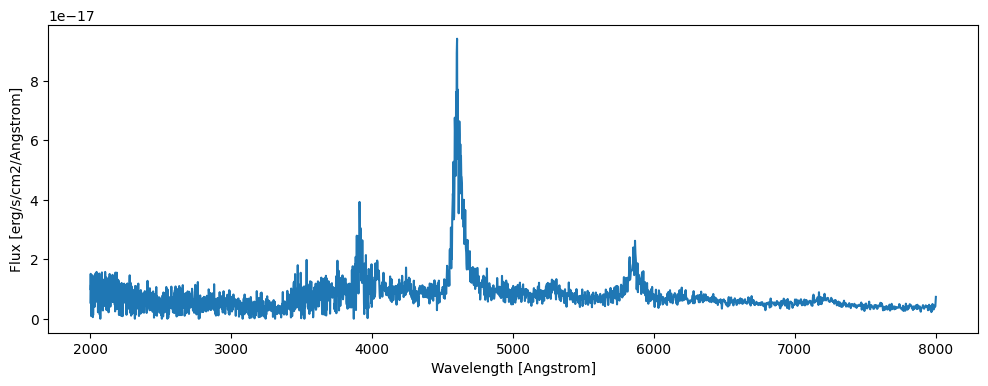

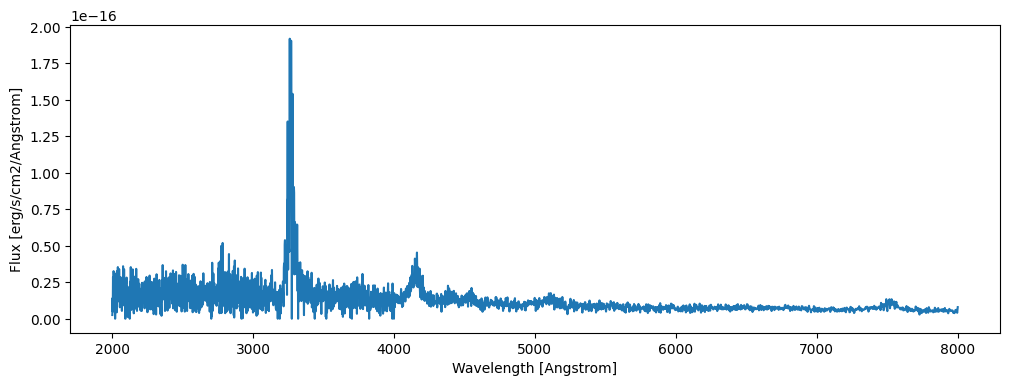

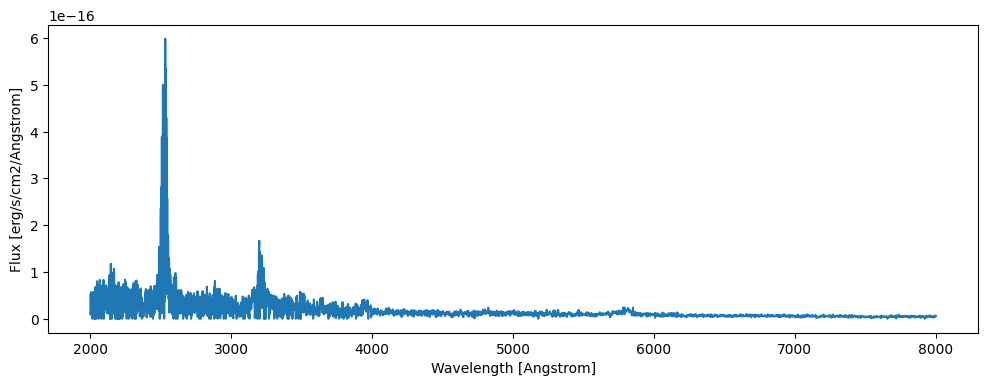

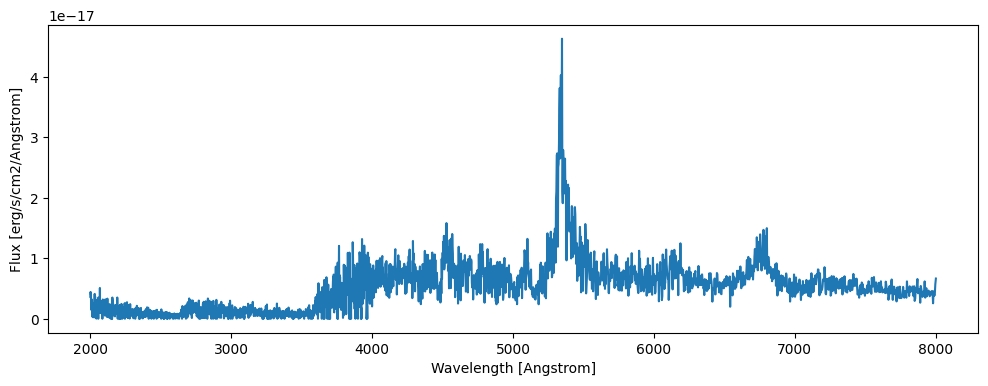

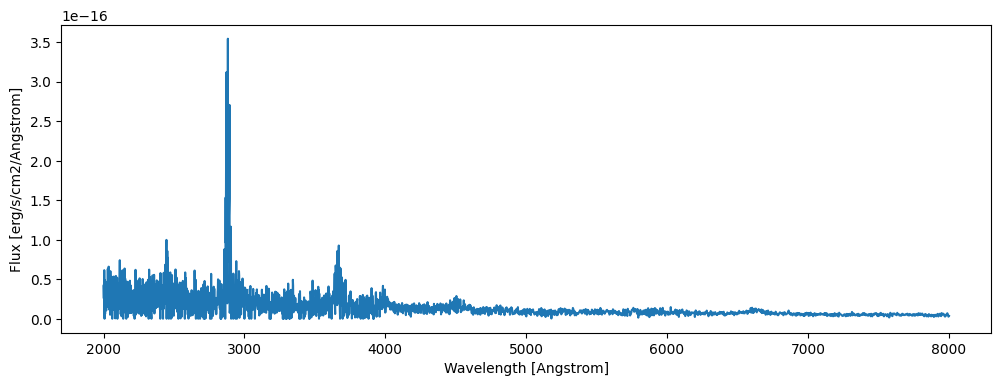

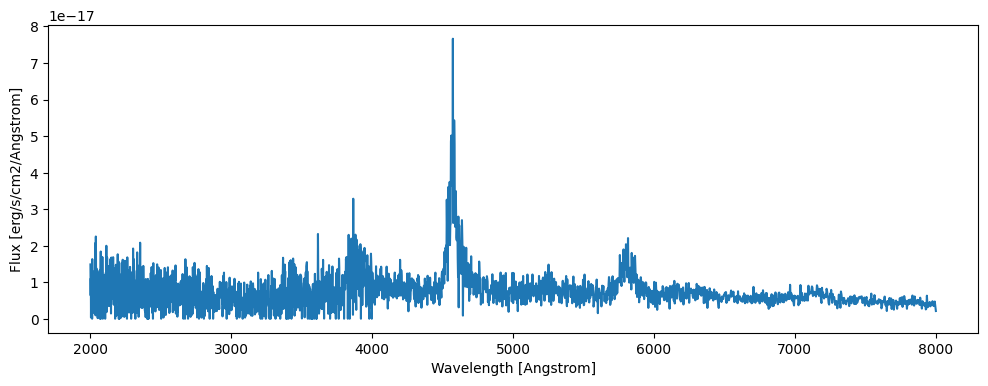

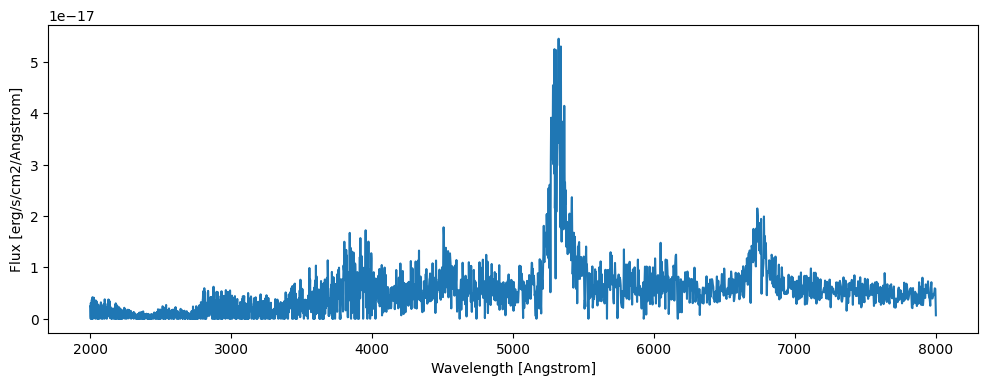

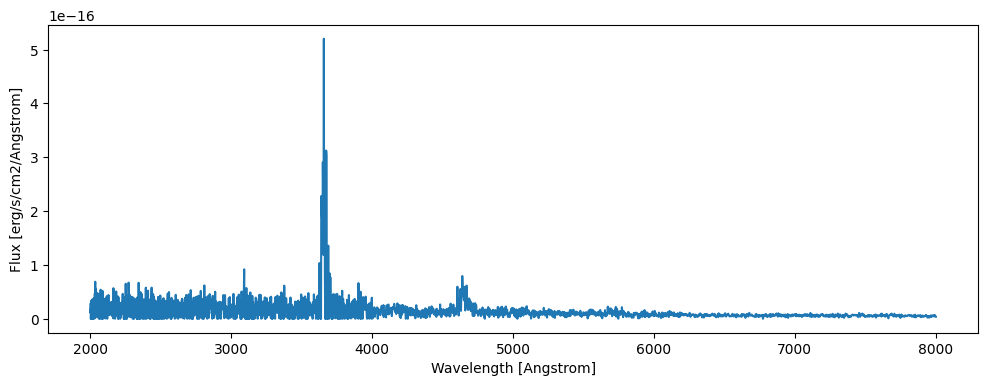

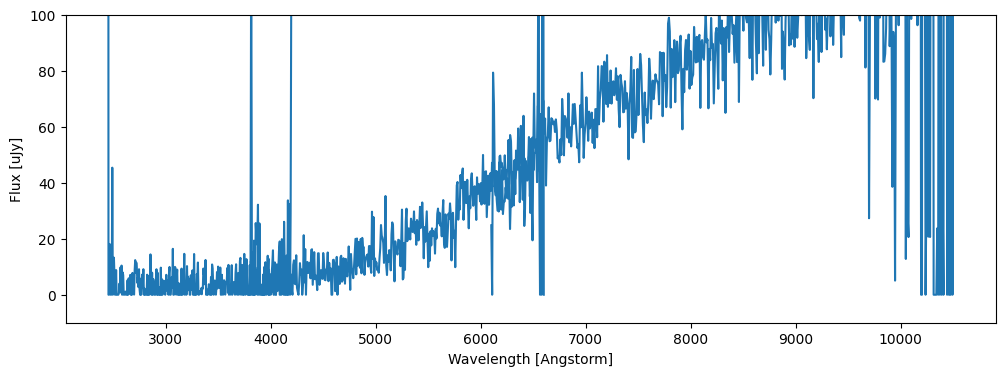

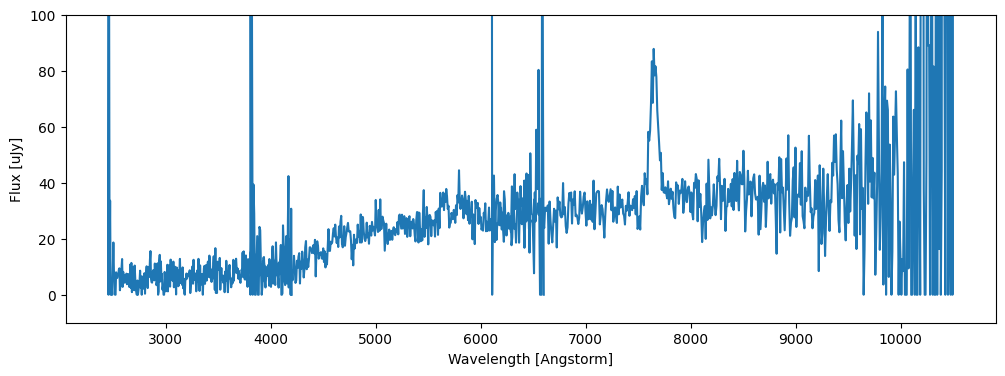

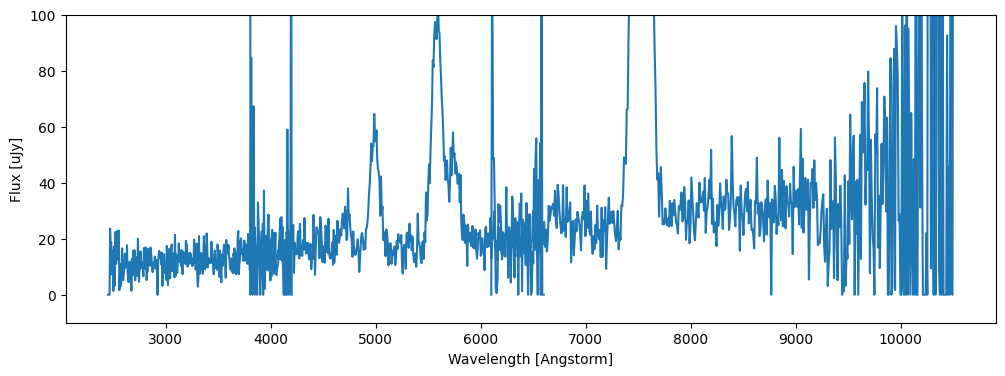

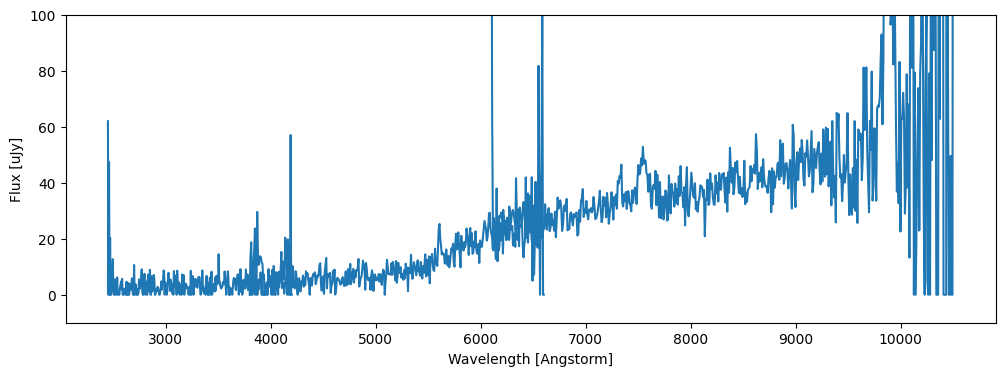

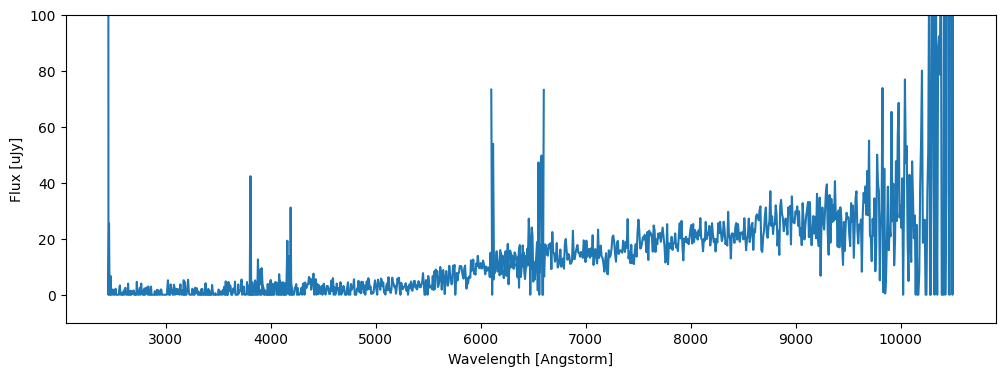

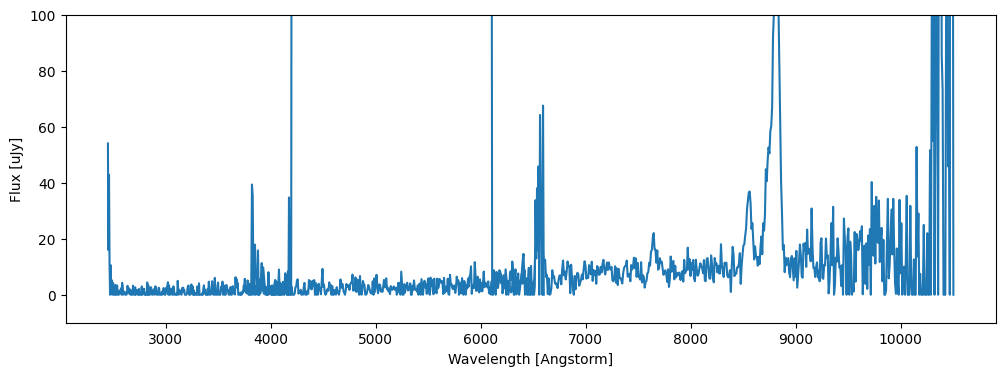

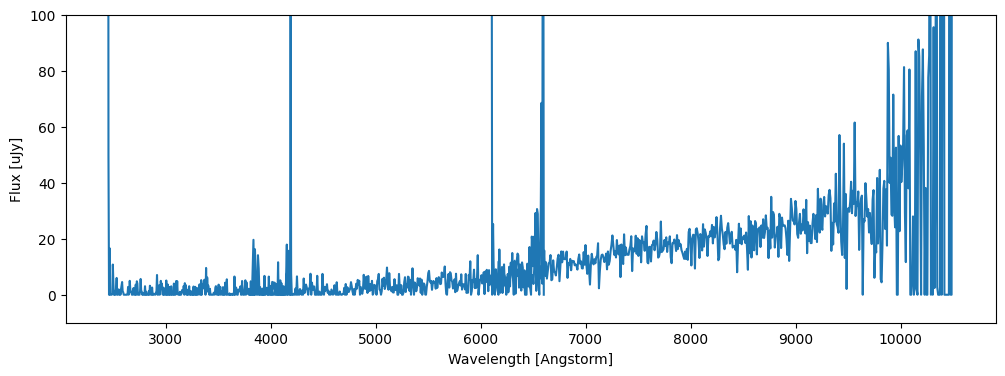

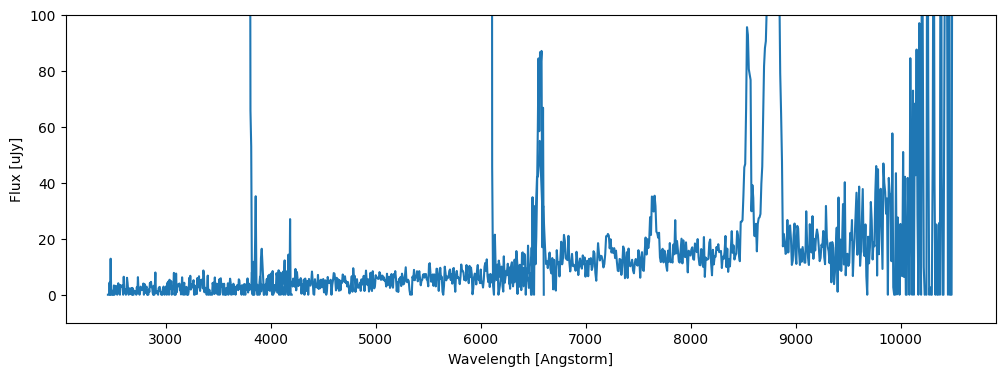

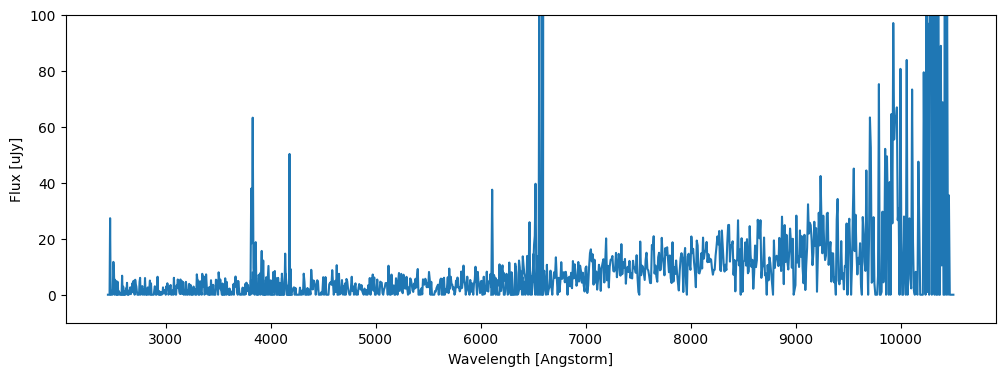

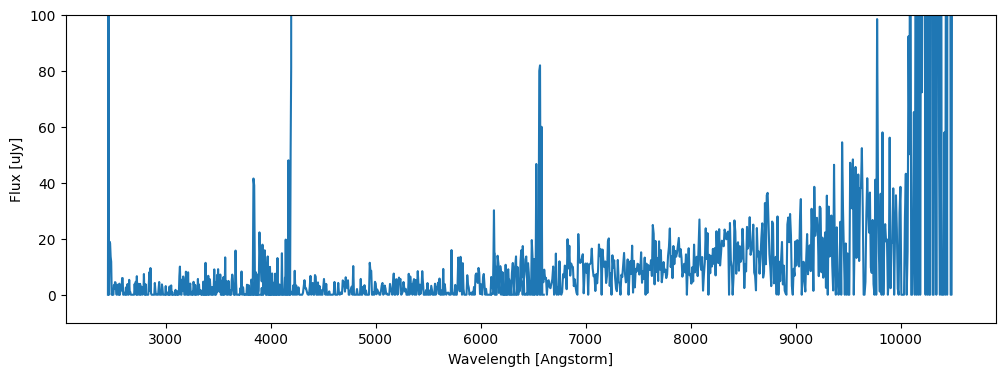

In [49]:
for xx in group1_indices:
    print(xx)
    if shuffled_samples[xx][1] == 'QSO':
        path = os.path.join(path_0, f"{xx}.fits")
        with fits.open(path) as hdul:
            print(hdul.info())
            wavelength = hdul[1].data
            flux = hdul[2].data
            flux_raw = hdul[3].data
        # 关闭hdul
        hdul.close()

        fig = plt.figure(figsize=(12, 4))
        plt.plot(wavelength, flux)
        plt.xlabel('Wavelength [Angstrom]')
        plt.ylabel('Flux [erg/s/cm2/Angstrom]')
        save_path = os.path.join('/home/wbc/code3/llm-spectro-agent/data/test_set_3/A', f"{xx}.png")
        fig.savefig(save_path, bbox_inches='tight')
    else:
        path = os.path.join(path_0, f"{xx}.fits")   
        # 读取 /home/wbc/CSST/dataset/865.fits
        fits_file = fits.open(path)
        u = fits_file['U_BAND'].data
        wl_u = u[:,0]
        fl_u = u[:,1]
        g = fits_file['G_BAND'].data
        wl_g = g[:,0]
        fl_g = g[:,1]
        i = fits_file['I_BAND'].data
        wl_i = i[:,0]
        fl_i = i[:,1]
        
        fig = plt.figure(figsize=(12, 4))
        plt.plot(wl_u, fl_u, c='C0')
        plt.plot(wl_g, fl_g, c='C0')
        plt.plot(wl_i, fl_i, c='C0')
        plt.ylim(-10,100)
        plt.ylabel('Flux [uJy]')
        plt.xlabel('Wavelength [Angstorm]')
        save_path = os.path.join('/home/wbc/code3/llm-spectro-agent/data/test_set_3/A', f"{xx}.png")
        fig.savefig(save_path, bbox_inches='tight')

18
Filename: /home/wbc/code3/llm-spectro-agent/data/test_set_3/0/18.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  WAVELENGTH    1 ImageHDU         7   (2774,)   float32   
  2  FLUX          1 ImageHDU         7   (2774,)   float32   
  3  FLUX_RAW      1 ImageHDU         7   (2774,)   float32   
None
22
Filename: /home/wbc/code3/llm-spectro-agent/data/test_set_3/0/22.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  WAVELENGTH    1 ImageHDU         7   (2774,)   float32   
  2  FLUX          1 ImageHDU         7   (2774,)   float32   
  3  FLUX_RAW      1 ImageHDU         7   (2774,)   float32   
None
20
Filename: /home/wbc/code3/llm-spectro-agent/data/test_set_3/0/20.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  WAVELENGTH    1 ImageHDU         7   (2774,)   fl

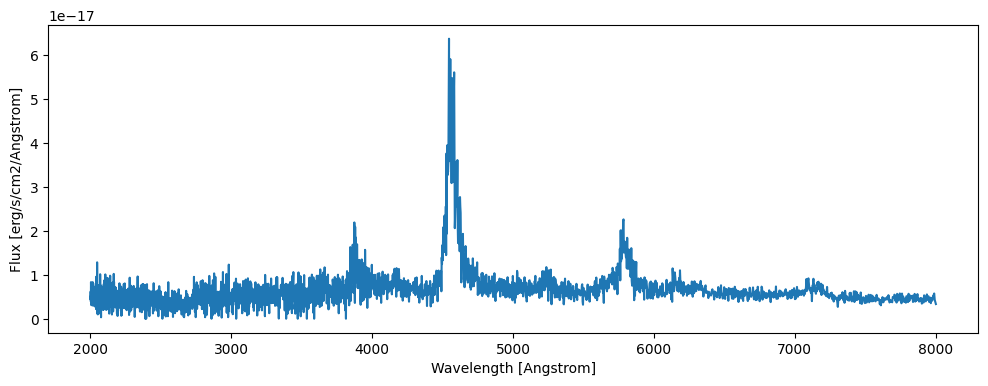

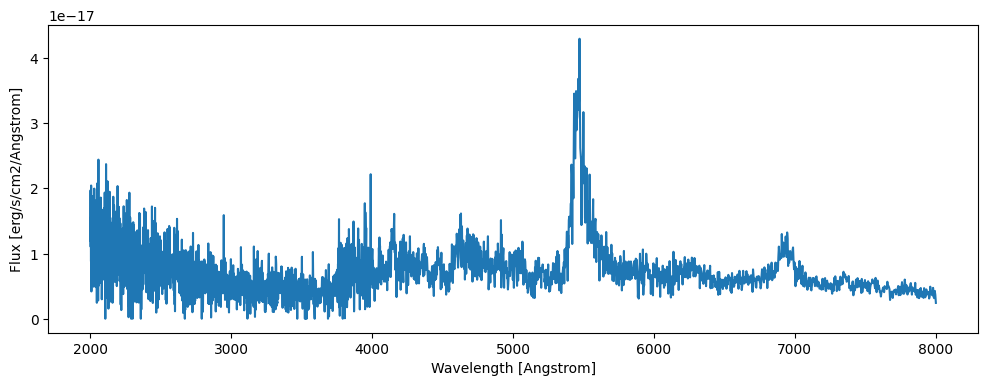

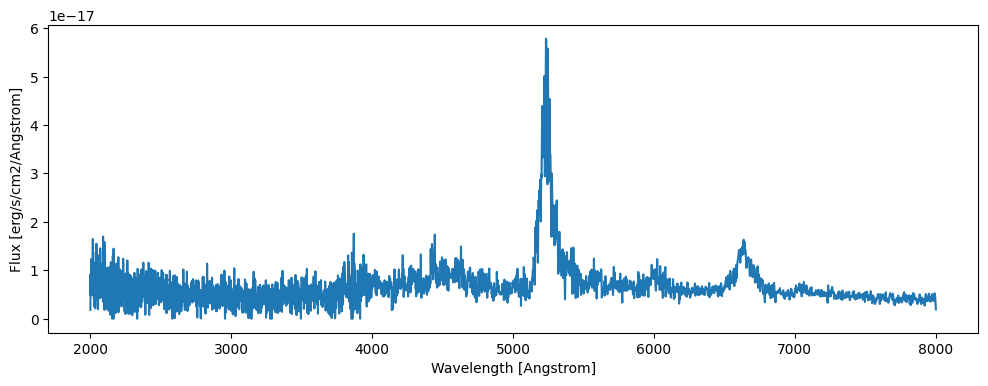

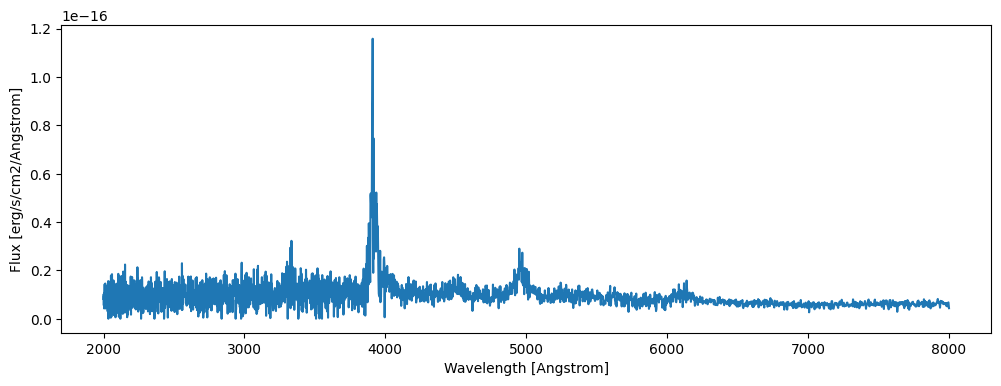

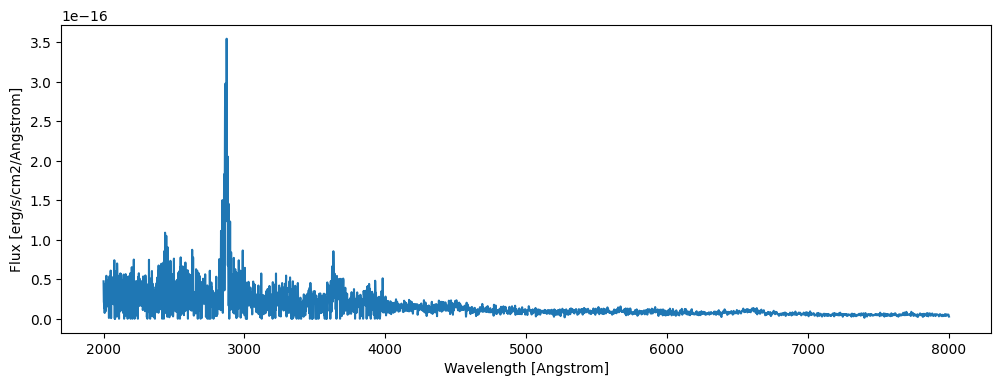

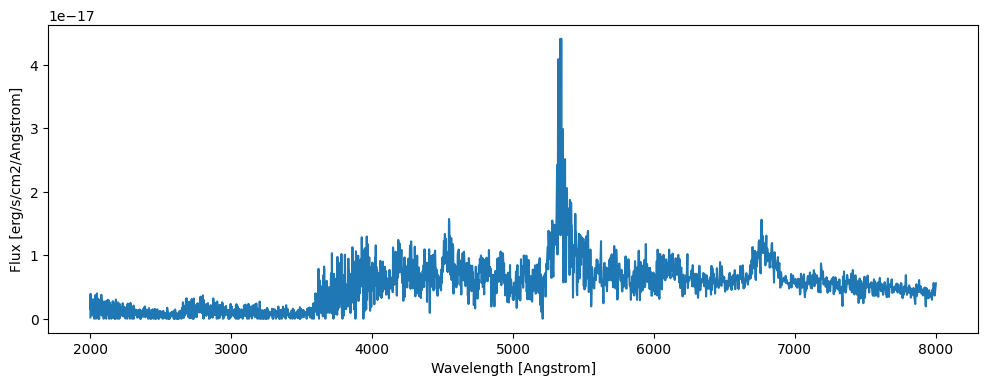

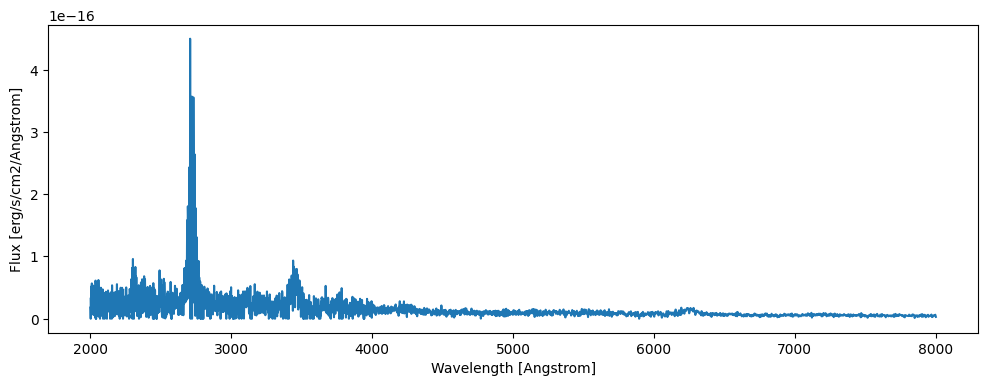

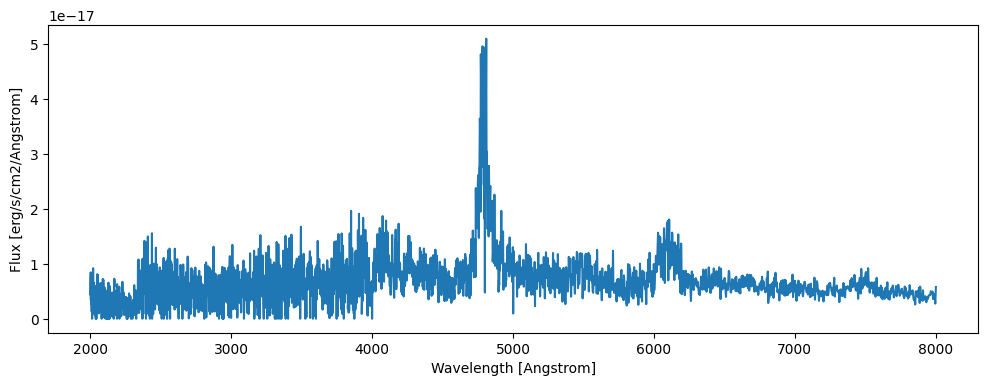

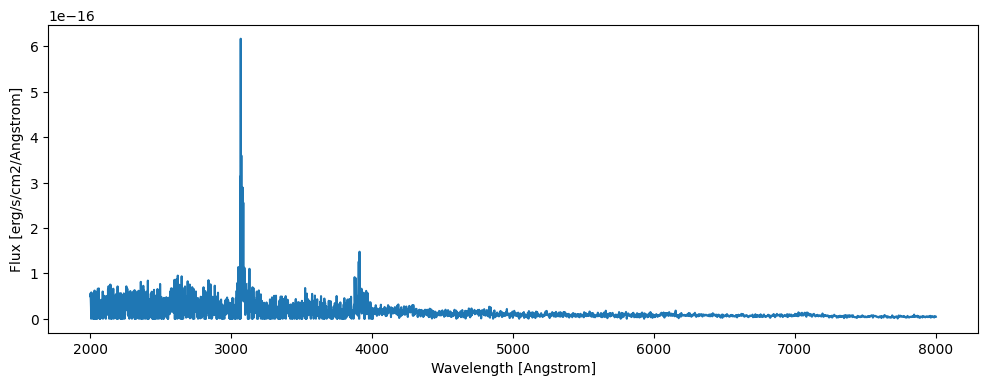

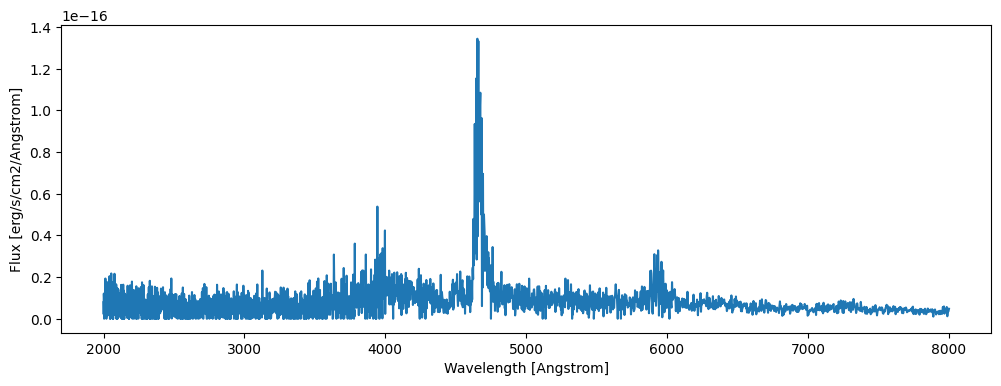

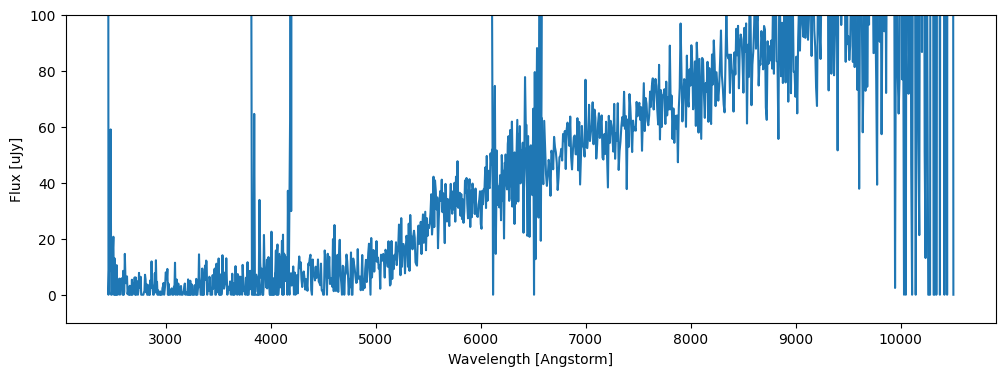

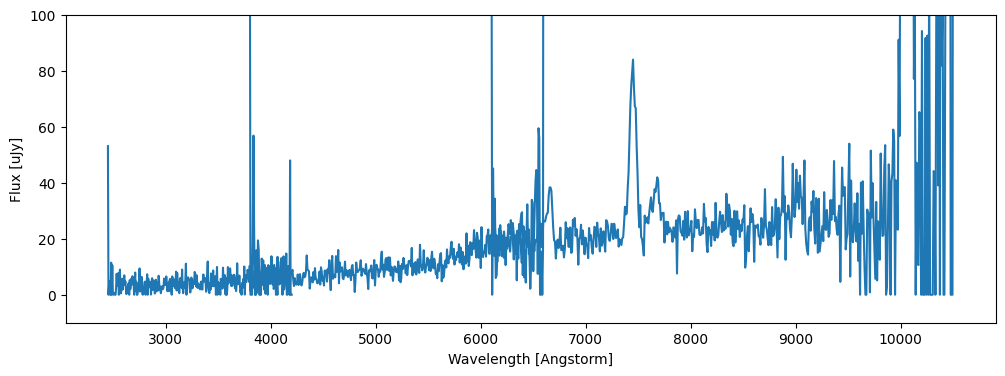

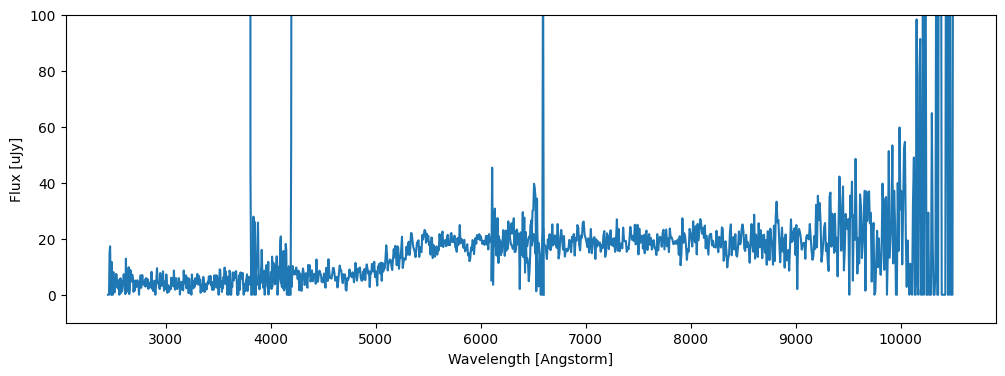

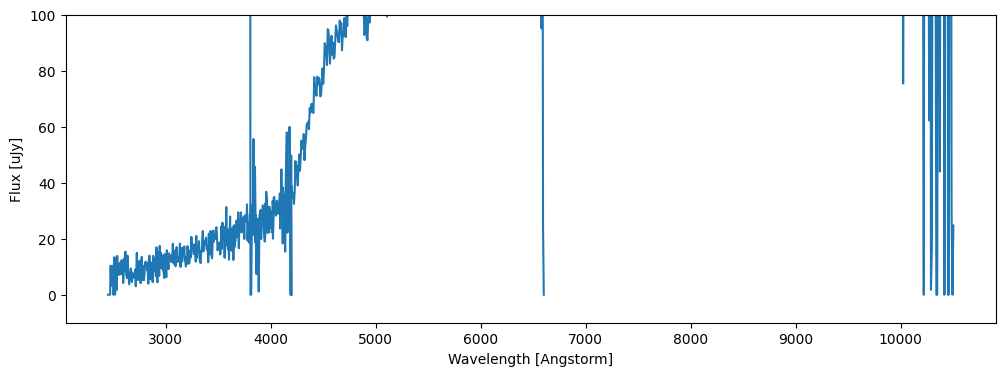

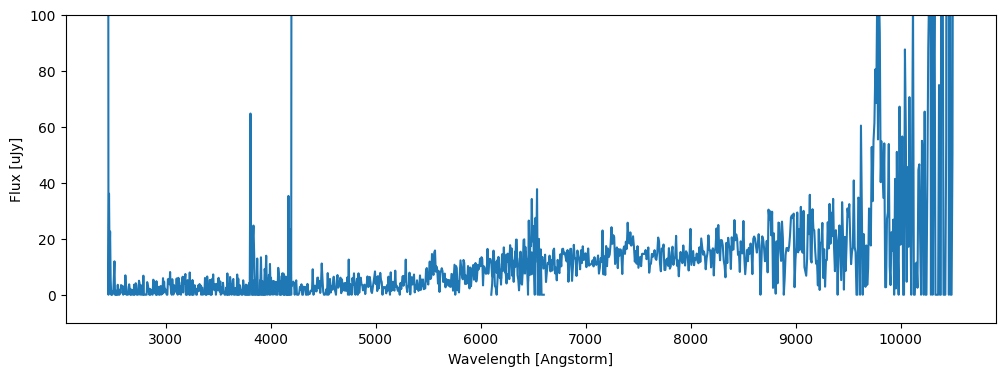

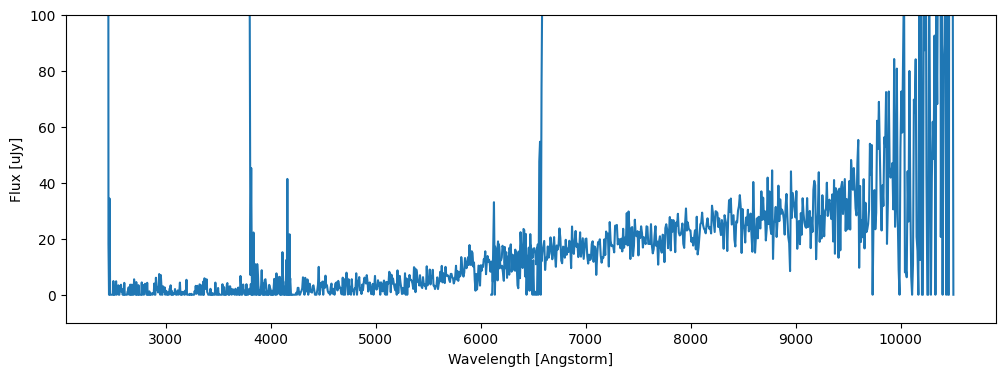

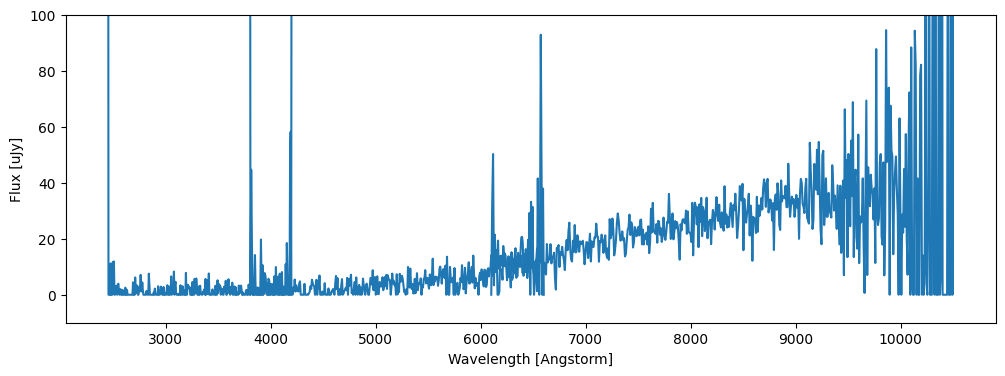

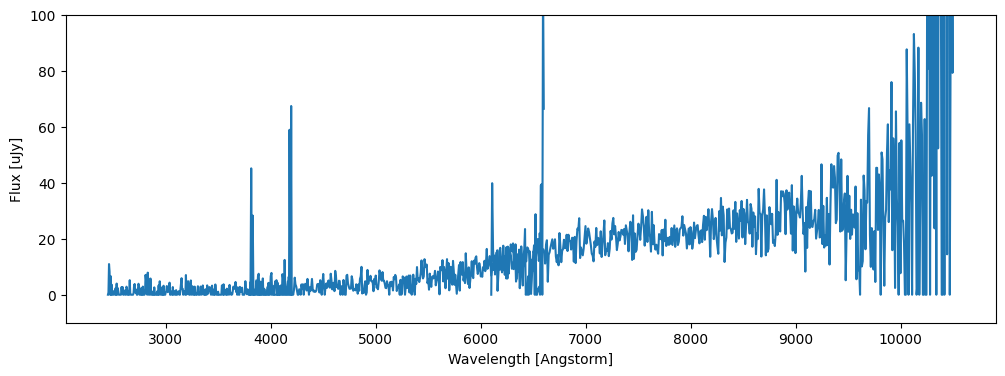

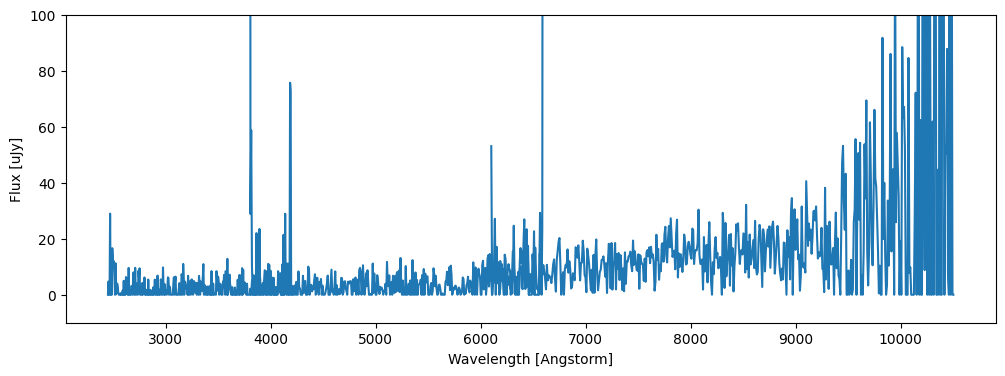

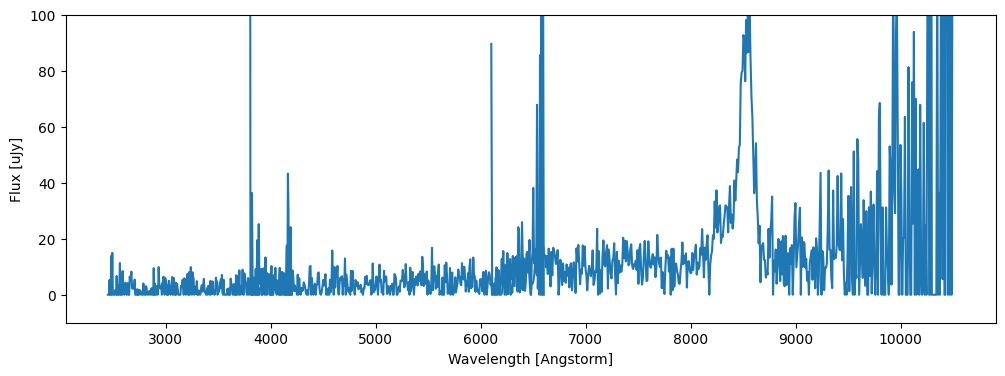

In [51]:
for xx in group2_indices:
    print(xx)
    if shuffled_samples[xx][1] == 'QSO':
        path = os.path.join(path_0, f"{xx}.fits")
        with fits.open(path) as hdul:
            print(hdul.info())
            wavelength = hdul[1].data
            flux = hdul[2].data
            flux_raw = hdul[3].data
        # 关闭hdul
        hdul.close()

        fig = plt.figure(figsize=(12, 4))
        plt.plot(wavelength, flux)
        plt.xlabel('Wavelength [Angstrom]')
        plt.ylabel('Flux [erg/s/cm2/Angstrom]')
        save_path = os.path.join('/home/wbc/code3/llm-spectro-agent/data/test_set_3/B', f"{xx}.png")
        fig.savefig(save_path, bbox_inches='tight')
    else:
        path = os.path.join(path_0, f"{xx}.fits")   
        # 读取 /home/wbc/CSST/dataset/865.fits
        fits_file = fits.open(path)
        u = fits_file['U_BAND'].data
        wl_u = u[:,0]
        fl_u = u[:,1]
        g = fits_file['G_BAND'].data
        wl_g = g[:,0]
        fl_g = g[:,1]
        i = fits_file['I_BAND'].data
        wl_i = i[:,0]
        fl_i = i[:,1]
        
        fig = plt.figure(figsize=(12, 4))
        plt.plot(wl_u, fl_u, c='C0')
        plt.plot(wl_g, fl_g, c='C0')
        plt.plot(wl_i, fl_i, c='C0')
        plt.ylim(-10,100)
        plt.ylabel('Flux [uJy]')
        plt.xlabel('Wavelength [Angstorm]')
        save_path = os.path.join('/home/wbc/code3/llm-spectro-agent/data/test_set_3/B', f"{xx}.png")
        fig.savefig(save_path, bbox_inches='tight')